# AMA Toolbox: Complete Analysis Workflow with Theory

## Overview

This comprehensive notebook demonstrates the complete `ama_tlbx` package functionality with accompanying mathematical theory and statistical concepts. The package provides a modern, modular architecture for applied multivariate analysis.

### Package Architecture

The `ama_tlbx` follows a **three-layer separation of concerns**:

1. **Data Handling Layer** (`data/`)
   - Dataset classes with preprocessing and validation
   - Column definitions with metadata (BaseColumn, LifeExpectancyColumn, SiebenkampfColumn)
   - Immutable DatasetView for analyzer isolation
   - Type-safe column access with IDE autocomplete

2. **Analysis Layer** (`analysis/`)
   - Pure computation modules (no plotting!)
   - CorrelationAnalyzer: Pearson correlation with target analysis
   - PCAAnalyzer: Principal Component Analysis with loadings
   - OutlierDetector: IQR, Z-Score, and IsolationForest strategies
   - Result classes for clean data packaging

3. **Visualization Layer** (`plotting/`)
   - Free functions consuming Result objects
   - Correlation heatmaps, pair plots, target correlations
   - PCA variance plots, loading heatmaps, biplots
   - Consistent styling and pretty labels

### Topics Covered

1. **Data Loading & Preprocessing** - Standardization theory and DatasetView pattern
2. **Correlation Analysis** - Pearson correlation coefficient and interpretation
3. **Principal Component Analysis (PCA)** - Dimensionality reduction mathematics
4. **Outlier Detection** - IQR, Z-Score, and Isolation Forest algorithms
5. **Visualization** - Publication-quality plots with matplotlib/seaborn
6. **Workflow Integration** - High-level API for repeatable analysis pipelines

### Mathematical Foundations

All algorithms are implemented with rigorous statistical foundations:
- **Standardization**: Z-score normalization for scale-invariant analysis
- **Correlation**: Pearson's $r$ for linear relationships
- **PCA**: Eigendecomposition of covariance matrices
- **Outlier Detection**: Statistical and ML-based approaches

## 1. Imports and Setup

All symbols are imported from the published package modules to showcase the complete public API.

### Package Structure
```
ama_tlbx/
├── data/
│   ├── BaseDataset, LifeExpectancyDataset
│   ├── BaseColumn, LifeExpectancyColumn, SiebenkampfColumn
│   └── DatasetView (immutable views)
├── analysis/
│   ├── CorrelationAnalyzer, CorrelationResult
│   ├── PCAAnalyzer, PCAResult
│   └── OutlierDetector (IQR, Z-Score, IsolationForest)
└──  plotting/
    ├── Correlation plots (heatmap, pairs, target)
    └── PCA plots (variance, loadings, biplot)
```

In [22]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from ama_tlbx.data import LifeExpectancyDataset, LECol
from ama_tlbx.analysis import (
    IQROutlierDetector,
    IsolationForestOutlierDetector,
    ZScoreOutlierDetector,
)
from ama_tlbx.plotting import (
    plot_correlation_heatmap,
    plot_explained_variance,
    plot_loadings_heatmap,
    plot_target_correlations,
    plot_top_correlated_pairs,
)

# Configure plotting
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["figure.dpi"] = 100


# same as LECol.LIFE_EXPECTANCY.pretty_name
print(f"Target column: {LECol.TARGET.pretty_name}")

Target column: Life Expectancy (years)


## 2. Data Loading & Preprocessing Theory

### 2.1 Why Standardization?

Features in multivariate datasets often have **different scales**:
- GDP: thousands to hundreds of thousands of dollars
- BMI: typically 15-40
- Immunization coverage: 0-100%

Without standardization, features with larger scales dominate distance-based analyses (PCA, clustering) and can skew correlation interpretations.

### 2.2 Z-Score Standardization Formula

For each feature $X$ with values $x_1, x_2, \ldots, x_n$:

$$
z_i = \frac{x_i - \mu}{\sigma}
$$

Where:
- $\mu = \frac{1}{n}\sum_{i=1}^{n} x_i$ (mean)
- $\sigma = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n}(x_i - \mu)^2}$ (standard deviation)

**Properties of standardized data:**
- $\mathbb{E}[Z] = 0$ (zero mean)
- $\text{Var}(Z) = 1$ (unit variance)
- Preserves relationships between observations
- Makes features comparable

### 2.3 Dataset Loading

`LifeExpectancyDataset` wraps CSV loading with automatic preprocessing:
- Column name normalization (removes trailing spaces, converts to snake_case)
- Type conversion (strings → floats where appropriate)
- Optional country-level aggregation (mean across years)
- Missing target handling

In [ ]:
DATA_DIR = Path.cwd().parent / "_data"
if not DATA_DIR.exists():
    DATA_DIR = Path.cwd() / "_data"

assert DATA_DIR.exists(), f"Data directory {DATA_DIR} does not exist."

# Load dataset with preprocessing
dataset = LifeExpectancyDataset.from_csv(
    DATA_DIR / "life_expectancy_data.csv",
    aggregate_by_country=True,  # Average across years per country
    drop_missing_target=True,  # Remove rows without life expectancy
)

print(f"   Shape: {dataset.df.shape}")
print(f"   Countries: {dataset.df.shape[0]}")
print(f"   Features: {dataset.df.shape[1] - len(dataset.identifier_columns)}")

print("\nColumn normalization examples:")
print(f"   'Life expectancy ' -> '{LECol.LIFE_EXPECTANCY}'")
print(f"   ' BMI ' -> '{LECol.BMI}'")
print(f"   'Income composition of resources' → '{LECol.INCOME_COMPOSITION}'")

# Display first few rows
dataset.df

   Shape: (183, 22)
   Countries: 183
   Features: 19

Column normalization examples:
   'Life expectancy ' → 'life_expectancy'
   ' BMI ' → 'bmi'
   'Income composition of resources' → 'income_composition_of_resources'


,country,adult_mortality,alcohol,bmi,diphtheria,gdp,hepatitis_b,hiv_aids,income_composition_of_resources,infant_deaths,...,percentage_expenditure,polio,population,schooling,thinness_1_19_years,thinness_5_9_years,total_expenditure,under_five_deaths,status,year
0,Afghanistan,269.0625,0.014375,15.51875,52.3125,340.015425,64.562500,0.10000,0.415375,78.2500,...,34.960110,48.3750,9.972260e+06,8.21250,16.58125,15.58125,8.252500,107.5625,Developing,2015-01-01
1,Albania,45.0625,4.848750,49.06875,98.0625,2119.726679,98.000000,0.10000,0.709875,0.6875,...,193.259091,98.1250,6.969116e+05,12.13750,1.61875,1.70000,5.945625,0.9375,Developing,2015-01-01
2,Algeria,108.1875,0.406667,48.74375,91.8750,2847.853392,78.000000,0.10000,0.694875,20.3125,...,236.185241,91.7500,2.164983e+07,12.71250,6.09375,5.97500,4.604000,23.5000,Developing,2015-01-01
3,Angola,328.5625,5.740667,18.01875,47.6875,1975.143045,70.222222,2.36875,0.458375,83.7500,...,102.100268,46.1250,1.014710e+07,8.04375,6.19375,6.66875,3.919333,132.6250,Developing,2015-01-01
4,Antigua and Barbuda,127.5000,7.949333,38.42500,98.3125,9759.305728,98.266667,0.12500,0.488625,0.0000,...,1001.585226,96.9375,1.274585e+07,8.84375,3.42500,3.37500,4.791333,0.0000,Developing,2015-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,Venezuela (Bolivarian Republic of),163.0000,7.420000,54.48750,68.5000,7389.061605,66.250000,0.10000,0.726812,9.3750,...,0.000000,74.6875,1.274585e+07,12.78750,1.65000,1.56250,4.998667,10.7500,Developing,2015-01-01
179,Viet Nam,126.5625,3.087333,11.18750,91.7500,7389.061605,87.538462,0.14375,0.627062,29.1875,...,0.000000,94.9375,1.274585e+07,11.51250,14.92500,15.62500,5.977333,36.5000,Developing,2015-01-01
180,Yemen,211.8125,0.047333,33.48750,72.6250,7389.061605,55.687500,0.10000,0.475500,39.3750,...,0.000000,67.1250,1.274585e+07,8.50625,13.83125,13.75000,5.005333,51.6250,Developing,2015-01-01
181,Zambia,354.3125,2.239333,17.45000,74.2500,811.811841,69.818182,11.93125,0.498437,33.4375,...,89.650407,64.3750,6.260246e+06,11.21250,6.88125,6.76250,5.824000,52.3750,Developing,2015-01-01


In [24]:
# Column metadata with pretty names
print("📋 Column Metadata System:\n")
print("Raw columns → Enum values → Pretty names\n")

sample_cols = [
    LECol.LIFE_EXPECTANCY,
    LECol.GDP,
    LECol.SCHOOLING,
    LECol.ADULT_MORTALITY,
    LECol.BMI,
]
for col in sample_cols:
    print(f"  {col:25s} → {col.pretty_name}")

print("\n💡 Benefits:")
print("   - Type-safe column access (IDE autocomplete)")
print("   - Consistent naming across analysis pipeline")
print("   - Automatic pretty labels for plots")
print("   - Documented original CSV column names")

📋 Column Metadata System:

Raw columns → Enum values → Pretty names

  life_expectancy           → Life Expectancy (years)
  gdp                       → GDP per Capita (USD)
  schooling                 → Schooling (years)
  adult_mortality           → Adult Mortality (per 1000)
  bmi                       → BMI (Average)

💡 Benefits:
   - Type-safe column access (IDE autocomplete)
   - Consistent naming across analysis pipeline
   - Automatic pretty labels for plots
   - Documented original CSV column names


### 2.4 DatasetView Pattern

The **DatasetView** is an immutable snapshot that:
- Isolates analyzers from dataset changes
- Provides consistent interface to analysis algorithms
- Includes metadata (pretty names, numeric columns, target)
- Can be standardized or raw

**Advantages:**
1. **Immutability**: Analyzers can't accidentally modify source data
2. **Flexibility**: Same dataset → multiple views (different columns, standardization)
3. **Clarity**: Explicit about what data is being analyzed

```python
@dataclass(frozen=True)
class DatasetView:
    data: pd.DataFrame
    pretty_by_col: Mapping[str, str]
    numeric_cols: list[str]
    target_col: str | None
```

In [25]:
# Select columns for analysis
selected_columns = [
    LECol.LIFE_EXPECTANCY,
    LECol.GDP,
    LECol.BMI,
    LECol.SCHOOLING,
    LECol.ALCOHOL,
    LECol.ADULT_MORTALITY,
]

# Create standardized view
view = dataset.analyzer_view(
    columns=selected_columns,
    standardized=True,  # Z-score standardization applied
    include_target=True,
)

print("  DatasetView created:")
print(f"   Shape: {view.data.shape}")
print("   Standardized: ✅")
print(f"   Target column: {view.target_col}")
print(f"   Numeric columns: {len(view.numeric_cols)}")
print("\n  Standardization verification:")
print(f"   GDP mean: {view.data[LECol.GDP].mean():.10f} (should be ~0)")
print(f"   GDP std:  {view.data[LECol.GDP].std():.10f} (should be ~1)")
print("\n  First 5 rows of standardized data:")

view.features.head()

  DatasetView created:
   Shape: (183, 6)
   Standardized: ✅
   Target column: life_expectancy
   Numeric columns: 6

  Standardization verification:
   GDP mean: 0.0000000000 (should be ~0)
   GDP std:  1.0027434894 (should be ~1)

  First 5 rows of standardized data:


,life_expectancy,gdp,bmi,schooling,alcohol,adult_mortality
0,-1.204107,-0.704098,-1.439609,-1.248518,-1.201290,1.086988
1,0.647432,-0.526330,0.686536,0.045449,0.061829,-1.248243
2,0.479607,-0.453601,0.665940,0.235011,-1.098793,-0.590156
3,-2.205603,-0.540772,-1.281178,-1.304150,0.294868,1.707284
4,0.636517,0.236753,0.012016,-1.040412,0.871946,-0.388821


In [26]:
# Compare raw vs standardized
print(" Raw vs Standardized Data Comparison:\n")

raw_view = dataset.analyzer_view(
    columns=selected_columns[:3], standardized=False, include_target=True
)
std_view = dataset.analyzer_view(
    columns=selected_columns[:3], standardized=True, include_target=True
)

comparison = pd.DataFrame(
    {
        "Feature": [
            LECol.LIFE_EXPECTANCY.pretty_name,
            LECol.GDP.pretty_name,
            LECol.BMI.pretty_name,
        ],
        "Raw Mean": [raw_view.data[col].mean() for col in selected_columns[:3]],
        "Raw Std": [raw_view.data[col].std() for col in selected_columns[:3]],
        "Std Mean": [std_view.data[col].mean() for col in selected_columns[:3]],
        "Std Std": [std_view.data[col].std() for col in selected_columns[:3]],
    }
)

print(comparison.to_string(index=False))

 Raw vs Standardized Data Comparison:

                Feature    Raw Mean      Raw Std      Std Mean  Std Std
Life Expectancy (years)   69.224932     9.186432 -7.231617e-16 1.002743
   GDP per Capita (USD) 7389.061605 10038.925845  5.824121e-17 1.002743
          BMI (Average)   38.235394    15.823028  1.310427e-16 1.002743


## 3. Correlation Analysis Theory

### 3.1 Pearson Correlation Coefficient

The Pearson correlation coefficient $r$ measures the **strength and direction** of the linear relationship between two variables $X$ and $Y$:

$$
r_{XY} = \frac{\text{Cov}(X, Y)}{\sigma_X \sigma_Y} = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2} \sqrt{\sum_{i=1}^{n}(y_i - \bar{y})^2}}
$$

**Properties:**
- $r \in [-1, 1]$
- $r = +1$: Perfect positive linear relationship (as $X$ increases, $Y$ increases proportionally)
- $r = -1$: Perfect negative linear relationship (as $X$ increases, $Y$ decreases proportionally)
- $r = 0$: No linear relationship (but non-linear relationships may exist!)
- $|r| > 0.7$: Strong correlation
- $0.3 < |r| < 0.7$: Moderate correlation
- $|r| < 0.3$: Weak correlation

**Important:** Correlation ≠ Causation! High correlation indicates association, not necessarily cause-and-effect.

### 3.2 Correlation Matrix

For $p$ features, the correlation matrix $\mathbf{R} \in \mathbb{R}^{p \times p}$ is:

$$
\mathbf{R} = \begin{bmatrix}
1 & r_{12} & \cdots & r_{1p} \\
r_{21} & 1 & \cdots & r_{2p} \\
\vdots & \vdots & \ddots & \vdots \\
r_{p1} & r_{p2} & \cdots & 1
\end{bmatrix}
$$

Properties:
- **Symmetric**: $r_{ij} = r_{ji}$
- **Diagonal**: $r_{ii} = 1$ (feature correlates perfectly with itself)
- **Positive semi-definite**: All eigenvalues $\geq 0$

### 3.3 Implementation

The `CorrelationAnalyzer` computes:
1. Full correlation matrix via `pandas.DataFrame.corr()`
2. Top correlated feature pairs (excluding diagonal and duplicates)
3. Feature-target correlations (if target exists)

In [27]:
# Create correlation analyzer using factory method
corr_analyzer = dataset.make_correlation_analyzer(
    columns=selected_columns,
    standardized=True,  # Use standardized data
    include_target=True,
)

# Compute all correlation results
corr_result = corr_analyzer.compute(top_n_pairs=10)

print("🔬 Correlation Analysis Results:")
print(f"   Matrix shape: {corr_result.matrix.shape}")
print(f"   Features analyzed: {len(corr_result.matrix.columns)}")
print(f"   Top pairs extracted: {len(corr_result.feature_pairs)}")
print(
    f"   Target correlations: {'✅' if corr_result.target_correlations is not None else '❌'}"
)

print("\n📊 Correlation matrix properties:")
print(f"   Symmetric: {np.allclose(corr_result.matrix, corr_result.matrix.T)}")
print(f"   Diagonal all 1s: {np.allclose(np.diag(corr_result.matrix), 1.0)}")

print("\n🔝 Top 5 correlated feature pairs:\n")
print(corr_result.feature_pairs.head(5).to_string(index=False))

🔬 Correlation Analysis Results:
   Matrix shape: (6, 6)
   Features analyzed: 6
   Top pairs extracted: 10
   Target correlations: ✅

📊 Correlation matrix properties:
   Symmetric: True
   Diagonal all 1s: True

🔝 Top 5 correlated feature pairs:

      feature_a       feature_b  correlation  abs_correlation                               pair
life_expectancy adult_mortality    -0.896441         0.896441 life_expectancy vs adult_mortality
life_expectancy       schooling     0.758339         0.758339       life_expectancy vs schooling
life_expectancy             bmi     0.716881         0.716881             life_expectancy vs bmi
            bmi       schooling     0.667069         0.667069                   bmi vs schooling
            bmi adult_mortality    -0.614564         0.614564             bmi vs adult_mortality


In [28]:
# Analyze target correlations
if corr_result.target_correlations is not None:
    print("🎯 Correlations with Life Expectancy (Target):\n")
    print("Top 5 Positive Correlations (strongest predictors):")
    print(corr_result.target_correlations.head(5).to_string(index=False))

    print("\nTop 5 Negative Correlations:")
    print(corr_result.target_correlations.tail(5).to_string(index=False))

    print("\n💡 Interpretation:")
    print("   Positive: Higher feature value → higher life expectancy")
    print("   Negative: Higher feature value → lower life expectancy")
    print("   |r| > 0.7: Strong relationship")
    print("   0.3 < |r| < 0.7: Moderate relationship")
else:
    print("No target column specified")

🎯 Correlations with Life Expectancy (Target):

Top 5 Positive Correlations (strongest predictors):
 correlation         feature
    0.758339       schooling
    0.716881             bmi
    0.579505             gdp
    0.458145         alcohol
   -0.896441 adult_mortality

Top 5 Negative Correlations:
 correlation         feature
    0.758339       schooling
    0.716881             bmi
    0.579505             gdp
    0.458145         alcohol
   -0.896441 adult_mortality

💡 Interpretation:
   Positive: Higher feature value → higher life expectancy
   Negative: Higher feature value → lower life expectancy
   |r| > 0.7: Strong relationship
   0.3 < |r| < 0.7: Moderate relationship


The heatmap visualises the symmetric correlation matrix using pretty labels.
Warm colours indicate strong positive relationships and cool tones highlight negative
relationships.

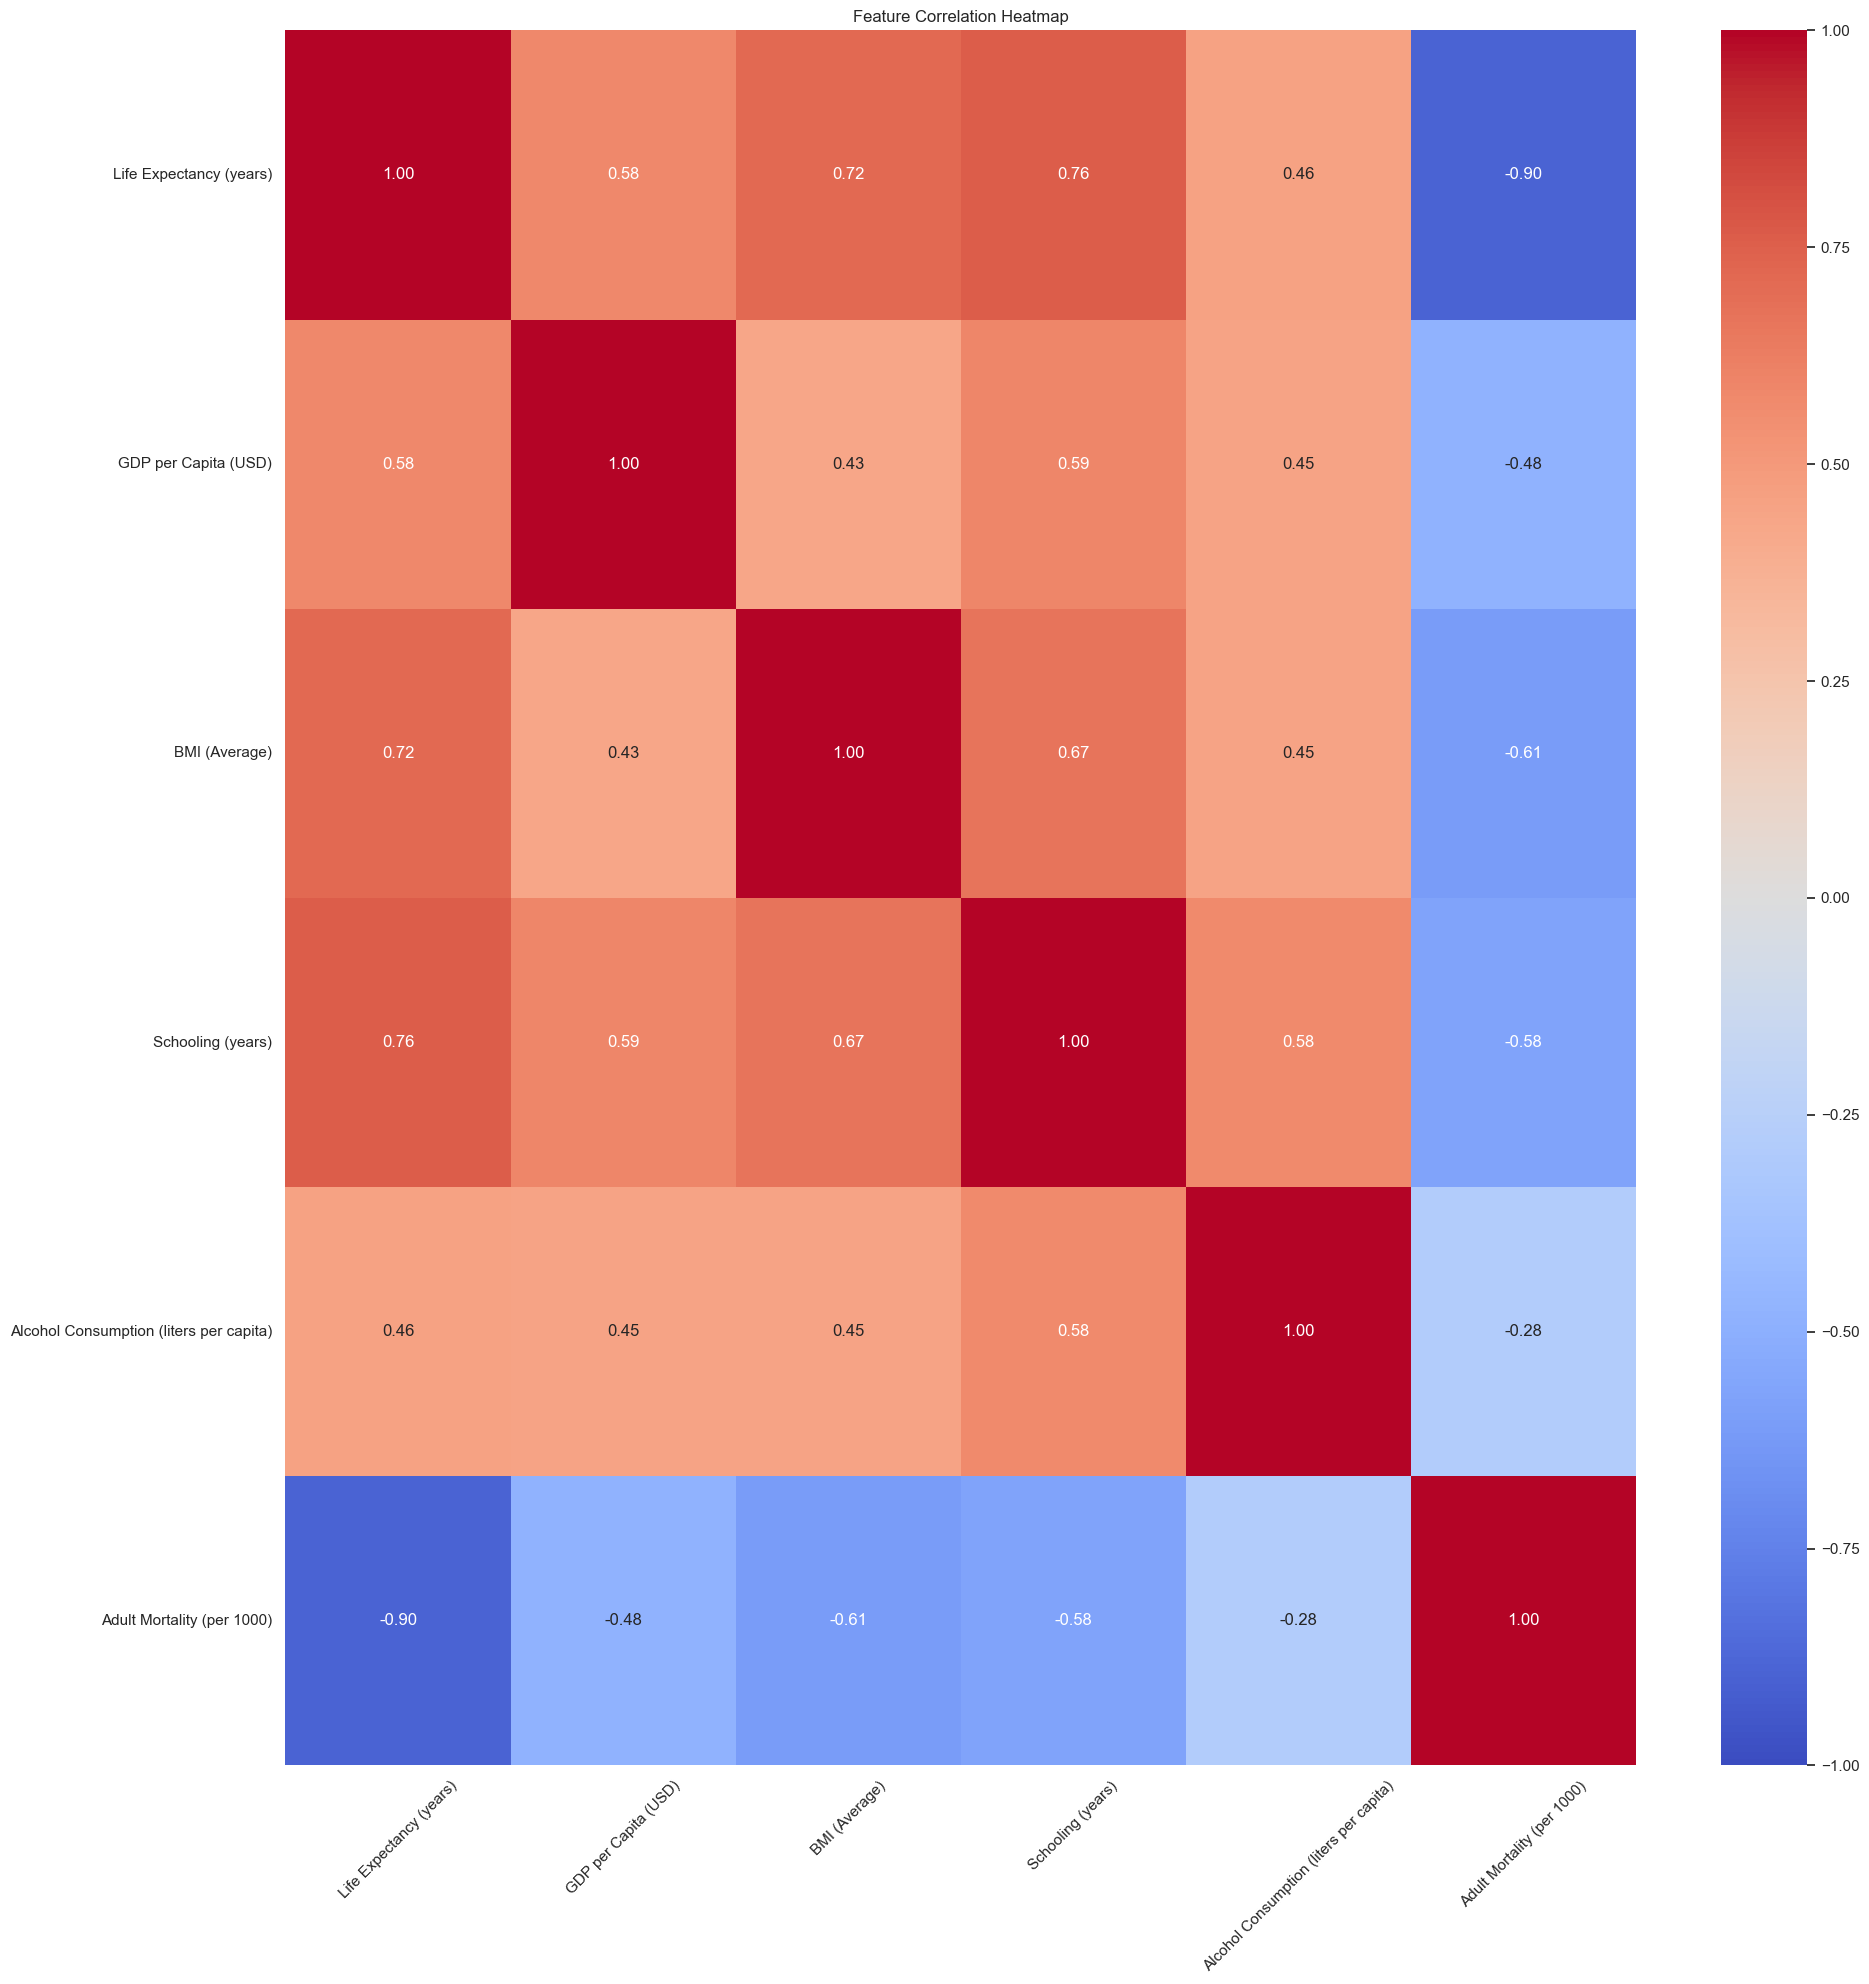

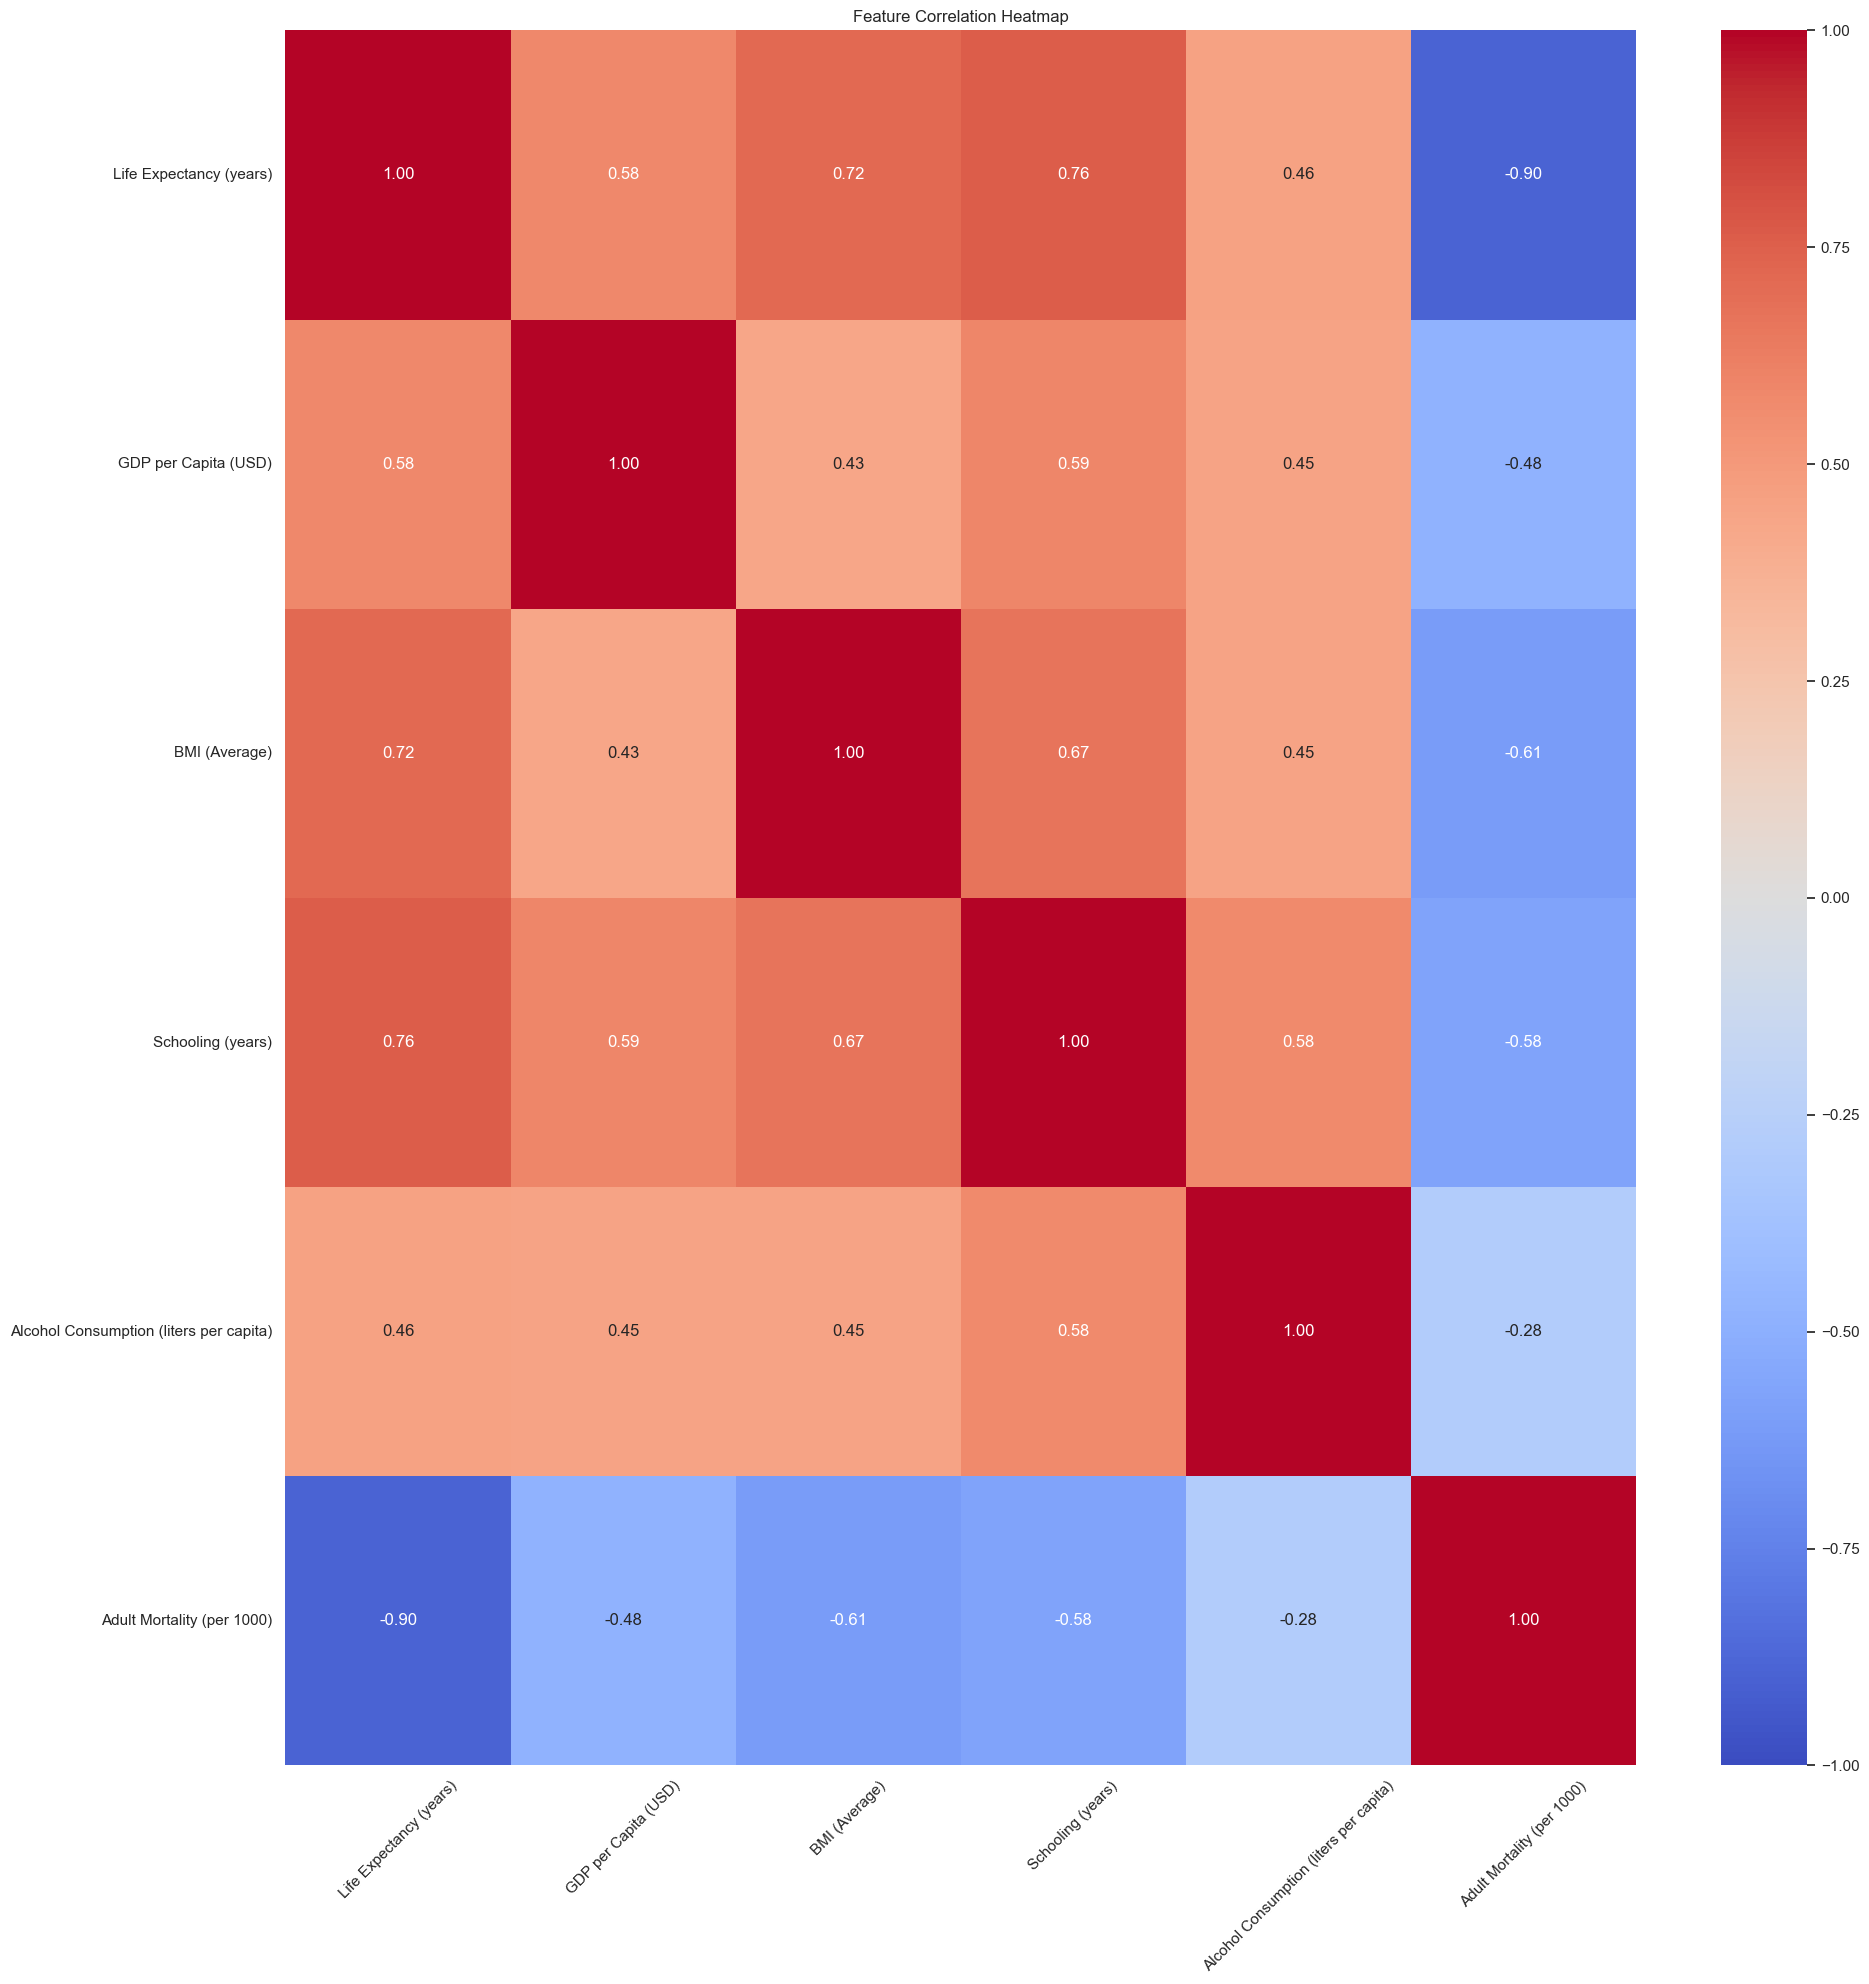

In [29]:
plot_correlation_heatmap(corr_result)

Bar charts highlight the strongest absolute correlations and the most influential
features with respect to the target variable.

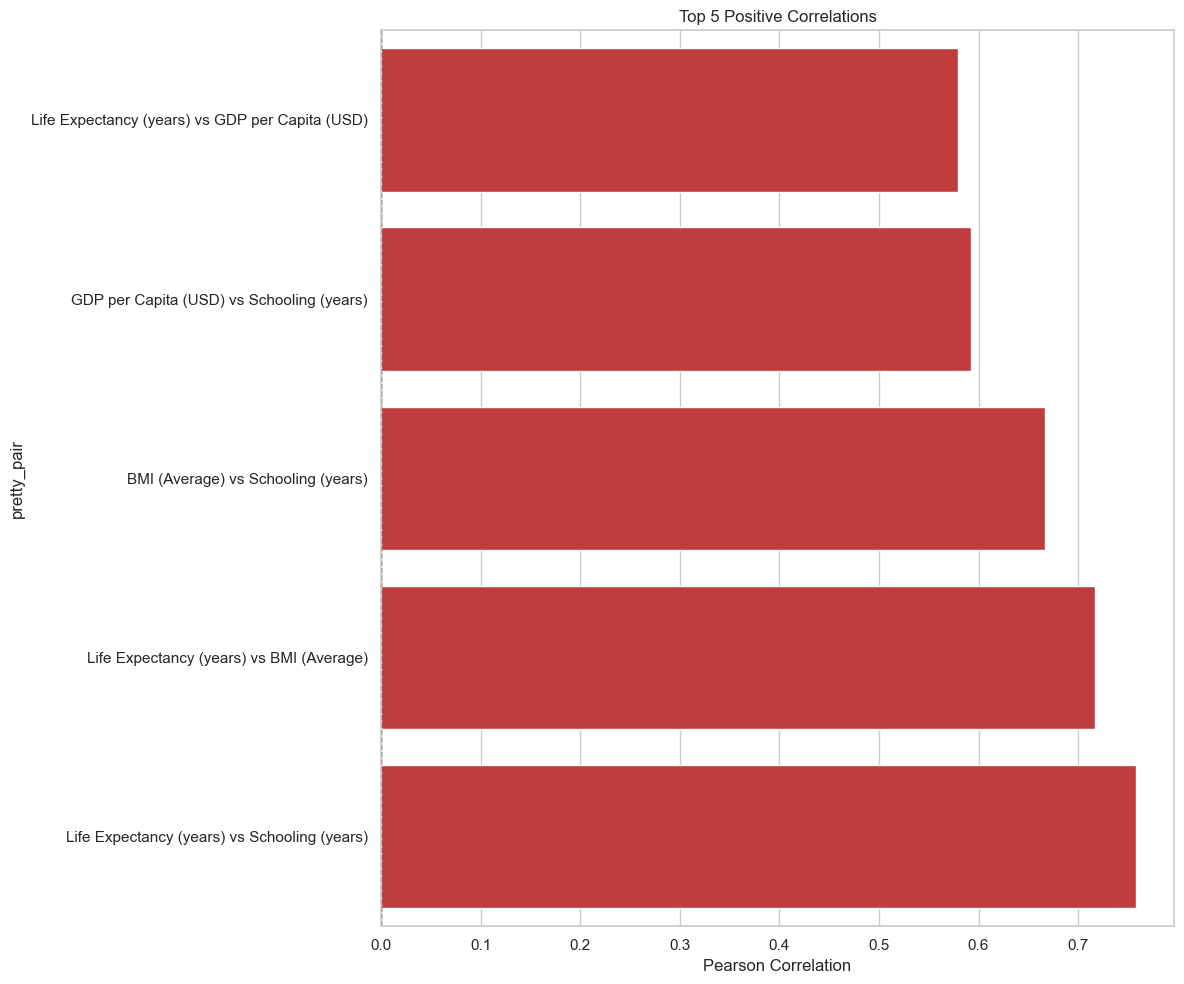

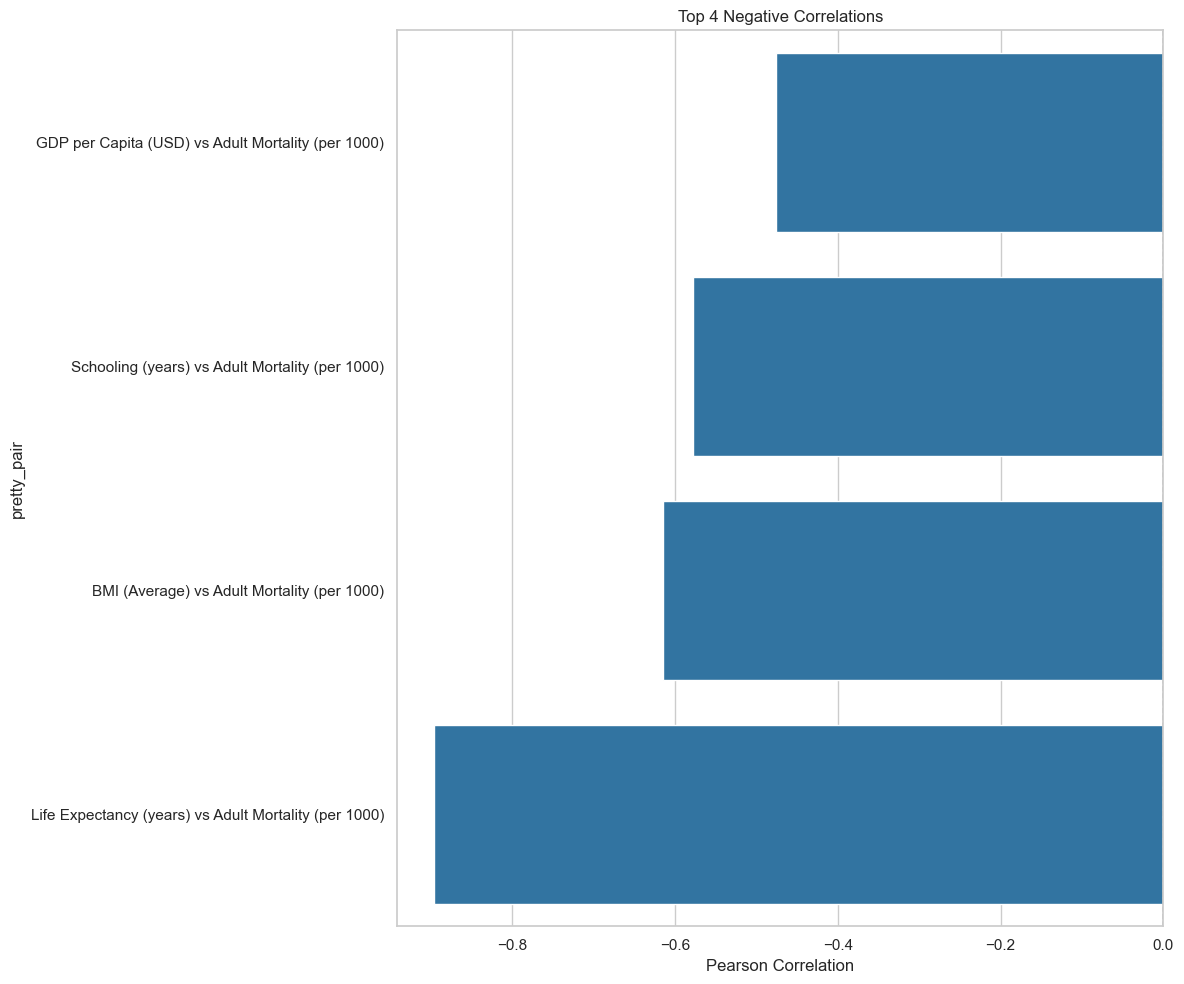

In [ ]:
plot_top_correlated_pairs(corr_result, n=5)
plt.show()

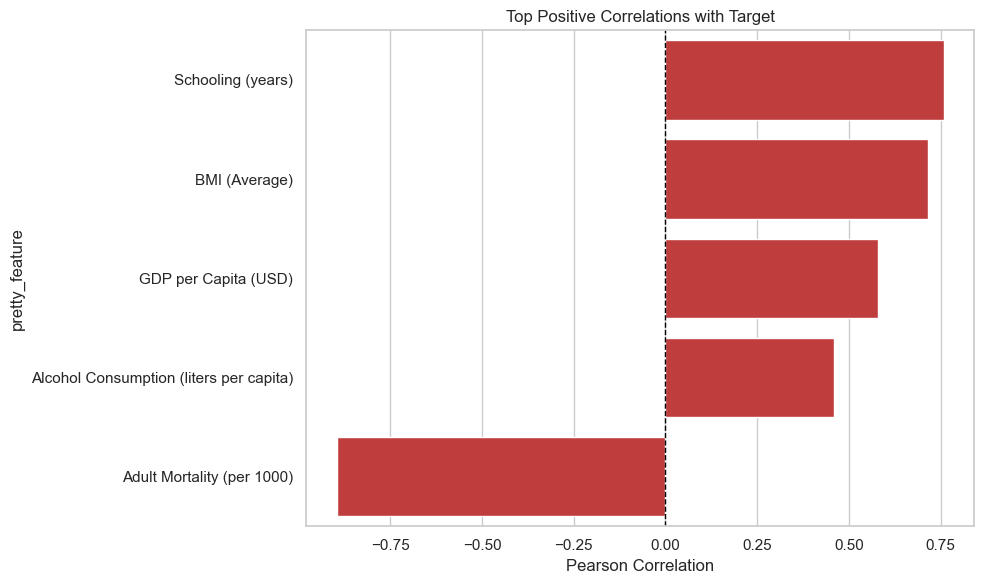

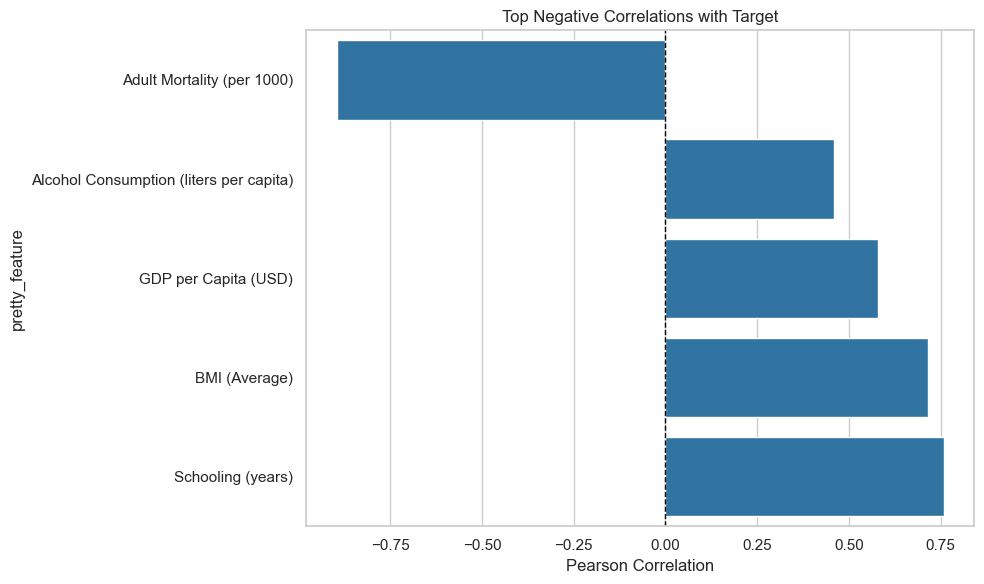

In [ ]:
plot_target_correlations(
    corr_result, n=5
) if corr_result.target_correlations is not None else None
plt.show()

## PCA analysis
Principal Component Analysis (PCA) projects the standardized matrix $\mathbf{X}$ onto the
orthogonal eigenvectors of its covariance matrix $\boldsymbol{\Sigma} = \frac{1}{n-1} \mathbf{X}^T \mathbf{X}$.
Components are ordered by variance (eigenvalues) computed via
[sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [32]:
pca_analyzer = dataset.make_pca_analyzer(
    columns=selected_columns[1:],
    standardized=True,
    exclude_target=True,
)
pca_analyzer.fit(n_components=3)
pca_result = pca_analyzer.result()
{
    "components": pca_result.scores.columns.tolist(),
    "explained": pca_result.explained_variance[
        ["explained_ratio", "cumulative_ratio"]
    ].head(3),
}

{'components': ['PC1', 'PC2', 'PC3'],
 'explained':    explained_ratio  cumulative_ratio
 0         0.613649          0.613649
 1         0.149607          0.763257
 2         0.113027          0.876283}

In [33]:
pca_result.loadings.head()

,PC1,PC2,PC3
gdp,0.428381,0.171644,0.821251
bmi,0.466727,-0.279658,-0.466245
schooling,0.504851,0.064495,-0.078659
alcohol,0.395612,0.723013,-0.312211
adult_mortality,-0.432750,0.604502,-0.067074


The explained-variance plot shows the variance share captured by each component and the
cumulative coverage across components.

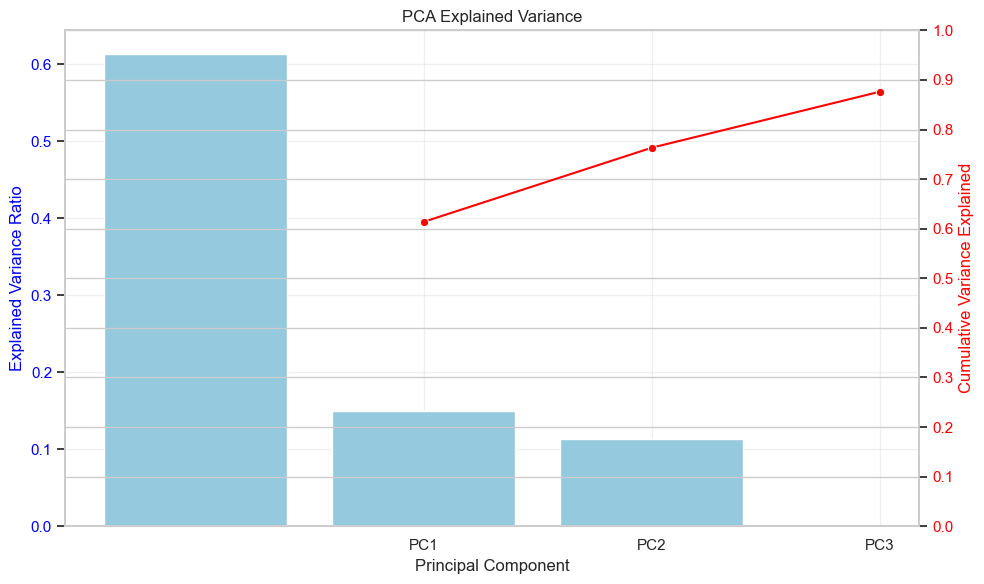

In [ ]:
plot_explained_variance(pca_result)
plt.show()

Component loadings quantify how strongly each original feature contributes to a
principal axis. The heatmap emphasises large magnitudes across the leading
components.

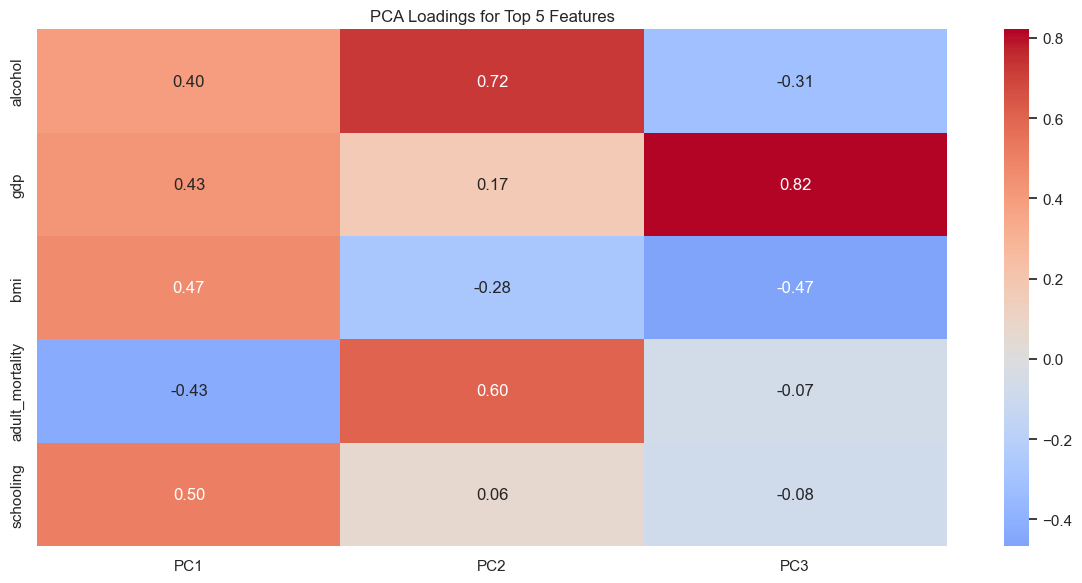

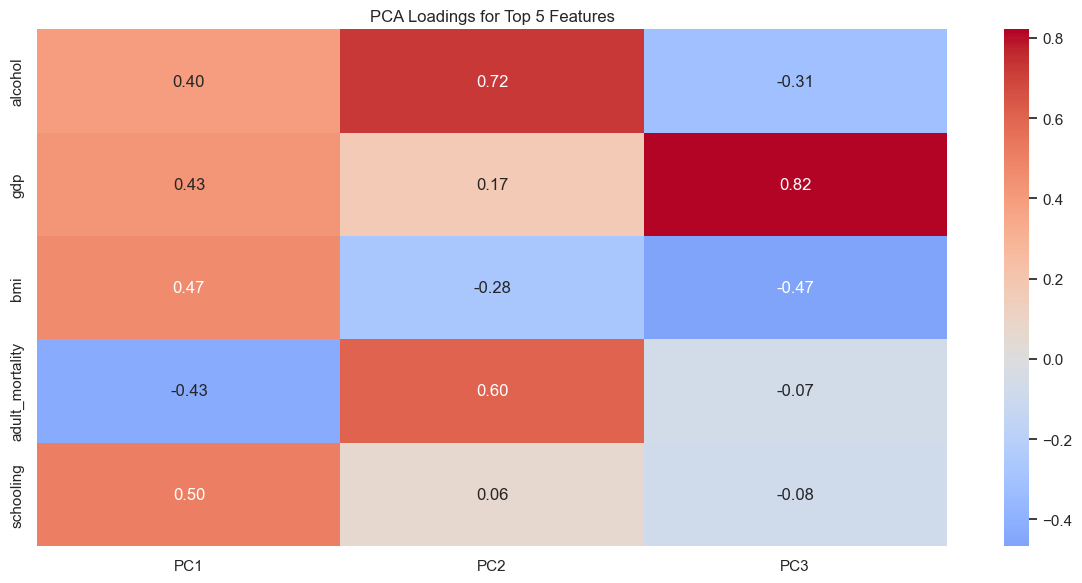

In [35]:
plot_loadings_heatmap(pca_result, n_components=3, top_n_features=5)

## Outlier detection
We compare three strategies:

- **IQR rule:** flags values outside $[Q_1 - k\cdot IQR,\, Q_3 + k\cdot IQR]$.
- **Z-score:** flags observations with $|z| > 	au$, where $z = 
rac{x - \mu}{\sigma}$.
- **Isolation Forest:** an ensemble method that isolates anomalies via random partitioning
  ([sklearn::IsolationForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)).

In [36]:
iqr_flags = dataset.detect_outliers(
    IQROutlierDetector(threshold=1.5),
    columns=selected_columns[1:],
    standardized=True,
)
zs_flags = dataset.detect_outliers(
    ZScoreOutlierDetector(threshold=2.5),
    columns=selected_columns[1:],
    standardized=True,
)

pd.DataFrame(
    {
        "feature": selected_columns[1:],
        "IQR outlier": iqr_flags.any(),
        "Z-score outlier": zs_flags.any(),
    }
)

,feature,IQR outlier,Z-score outlier
gdp,gdp,True,True
bmi,bmi,False,False
schooling,schooling,True,True
alcohol,alcohol,False,False
adult_mortality,adult_mortality,True,True


In [37]:
iso_flags = dataset.detect_outliers(
    IsolationForestOutlierDetector(contamination=0.05, random_state=42),
    columns=selected_columns[1:],
    standardized=True,
)
iso_flags.any().rename("IsolationForest outlier")

gdp                True
bmi                True
schooling          True
alcohol            True
adult_mortality    True
Name: IsolationForest outlier, dtype: bool